In [28]:
# neccessities for the project setup
# this enables automatic reload of the libraries specific to this project
%load_ext autoreload
%autoreload 1

import os
import sys

# fs_utils.py stores paths to every other directory in the projects
# this module is located at the top level of the repository
# jupyter can't see it unless I change the cwd manually
# official man page tells that it's not actually possible in any other way
sys.path.append(os.path.abspath(".."))
%aimport fs_utils

# extend != append, the former appends the content while 
# the latter — the list with two elements...
os.chdir(fs_utils.ROOT_DIR)
sys.path.extend([fs_utils.LIB_DIR, fs_utils.ROOT_DIR, fs_utils.SRC_DIR])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# standard library
import gc
import pickle
import multiprocessing as mp

gc.enable()

In [30]:
# third-party modules
from collections import defaultdict, OrderedDict
from joblib import Parallel, delayed
import igraph as ig
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%aimport matplotlib.font_manager
import numpy as np
import pandas as pd
import psutil
import scipy.stats as sps
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm_notebook

%matplotlib inline

In [31]:
# custom modules
%aimport util
%aimport qtls
%aimport networks
%autosave 15

Autosaving every 15 seconds


In [32]:
qtls_df = {
    "eQTLs_2011" : {
        "naive" : pd.read_table("./data/processed/eQTLs/2011/qtls_naive.csv"),
        "limix" : pd.read_table("./data/processed/eQTLs/2011/qtls_limix.csv")
    },
    "eQTLs_2018" : { 
        "A&B" : pd.read_table("./data/processed/eQTLs/2018/qtls_albert&bloom_from_paper.csv"),
        "limix" : pd.read_table("./data/processed/eQTLs/2018/qtls_limix.csv")
    }, 
    "pQTLs_2011" : {
        "naive" : pd.read_table("./data/processed/pQTLs/2011/qtls_naive.csv"),
        "limix" : pd.read_table("./data/processed/pQTLs/2011/qtls_limix.csv")
    }
}
scaler_df = {
    "eQTLs_2018" : {
        "A&B" : MinMaxScaler()
    }
}
qtls_df["eQTLs_2011"]["naive"]["score"] = qtls_df["eQTLs_2011"]["naive"]["q_value"]
qtls_df["pQTLs_2011"]["naive"]["score"] = qtls_df["pQTLs_2011"]["naive"]["q_value"]
qtls_df["eQTLs_2018"]["A&B"]["score"] = (1 - scaler_df["eQTLs_2018"]["A&B"]\
                                               .fit_transform(
                                                    qtls_df["eQTLs_2018"]["A&B"]["LOD"].values[:,None]
                                                )
                                          )
for qtl_type in ["eQTLs_2011", "eQTLs_2018", "pQTLs_2011"]:
    qtls_df[qtl_type]["limix"]["score"] = qtls_df[qtl_type]["limix"]["q_value"]

# Physical and genetic interactions taken from TheBioGrid project
interactome_df = pd.read_table("./data/raw/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[
#     full_interactome_df['Publication year'] <= 2011]

genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association", 
    "colocalization", 
    "direct interaction",
    "physical association"
]

In [33]:
interactome_df.set_index('Interaction Type', inplace=True)

genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]

interaction_categories = (genetic_interaction_categories 
                          + physical_interaction_categories 
                          + ["all", "physical", "genetic"])

def extract_interactions(interactions_df):
    ''' Helper function to retrieve the edges of the graph of interactions '''
    return interactions_df[["Interactor A", "Interactor B"]].values

type2interactome = {}
for edge_type in interaction_categories:
    with open("./data/raw/interactions/{}_interactions_graph.pkl".format(edge_type), "rb") as infile:
        type2interactome[edge_type] = pickle.load(infile)

In [34]:
category = {"all" : "all"}
for edge_type in physical_interaction_categories + ["physical"]:
    category[edge_type] = "physical"
for edge_type in genetic_interaction_categories + ["genetic"]:
    category[edge_type] = "genetic"

## Implementation
**Introduction — interacting vs. random:**  
*“Interacting genes share more linkages than expected at random. The observation is robust under structure-preserving graph randomization.”*  

- For each edge, compute the Jaccard coefficient of the sets of markers linked to its endpoints. 
- Then create several thousands of random graphs using structure-preserving randomization of the interactome graph and compute the coefficients. 

Compare distributions of Jaccard coefficients through such statistics, as:

- p-value from MWU test
- mean value
- confidence intervals

A class generating this figure must reside in `qtls` module and be well-documented. 
Let's call it `RandomizedInteractomeTest`.  
I am very glad, that this test is already implemented. We just have to call it properly.

## Running the test suite on Albert&Bloom's eQTLs. 

As test requires a `score` feature, I applied min-max normalization to LOD scores provided in A&B's dataset and inverted the values: 

$$\mathrm{score} = 1 - \mathrm{MinMaxScale(LOD)}$$

It's necessary to subtract the normalized value, because by design it's expected that the less the score the better.

### Computing similarity curves

In [35]:
""" Run simulations from scratch and dump results on disk. """

score_thresholds = np.linspace(0.8, 1, 10) # chosen empirically

In [9]:
assert np.all(score_thresholds == np.linspace(0.8, 1, 10))    
type2simulation_results = {}
for edge_type in tqdm_notebook(["physical"]):
    print(edge_type)
    spr_test = qtls.RandomizedInteractomeTest(
        interactome=type2interactome[edge_type], 
        interactions_type=category[edge_type],
        qtls_df=qtls_df["eQTLs_2018"]["A&B"],
        score_thresholds=score_thresholds,
        path_to_randomized="data/raw/randomized_interactome_copies/",
        max_iter=128, 
        n_jobs=score_thresholds.size
    )
    type2simulation_results[edge_type] = spr_test.map_reduce()

physical



In [244]:
# with open("data/tmp/figure-2/type2simulation_results_A&B_eQTLs_2018.pkl", "wb") as outfile:
#     pickle.dump(type2simulation_results, outfile)

In [245]:
with open("data/tmp/figure-2/type2simulation_results_A&B_eQTLs_2018.pkl", "rb") as infile:
    type2simulation_results = pickle.load(infile)

### Comparing distributions of Jaccard coefficients:

In [16]:
spr_test = qtls.RandomizedInteractomeTest(
    interactome=type2interactome["physical"], 
    interactions_type=category["physical"],
    qtls_df=qtls_df["eQTLs_2018"]["A&B"],
    score_thresholds=score_thresholds,
    path_to_randomized="data/raw/randomized_interactome_copies/",
    max_iter=128, 
    n_jobs=score_thresholds.size)

j_distr_dct = spr_test.aggregate_jaccard_distributions(
    threshold=1.0, 
    n_iter=128, 
    agg_f=lambda v: (v.size, (v == 0).sum())
)

In [18]:
fisher_pvalue_lst = []
for i in tqdm_notebook(range(128)):
    n, real_0 = j_distr_dct["real"]
    n, random_0 = j_distr_dct["random_{}".format(i)]
    crosstab = pd.DataFrame([[real_0, n - real_0], [random_0, n - random_0]], 
                            columns=["== 0", "> 0"], 
                            index=["real", "random"])
    odds, pvalue = sps.fisher_exact(crosstab)
    fisher_pvalue_lst.append(pvalue)
signif, fisher_pvalue_lst, _, _ = multipletests(fisher_pvalue_lst)
print(signif.mean())

1.0


In [19]:
crosstab

,== 0,> 0
real,76697,13262
random,78868,11091


In [39]:
j_distr_dct = spr_test.aggregate_jaccard_distributions(
    threshold=1.0, 
    n_iter=5
)

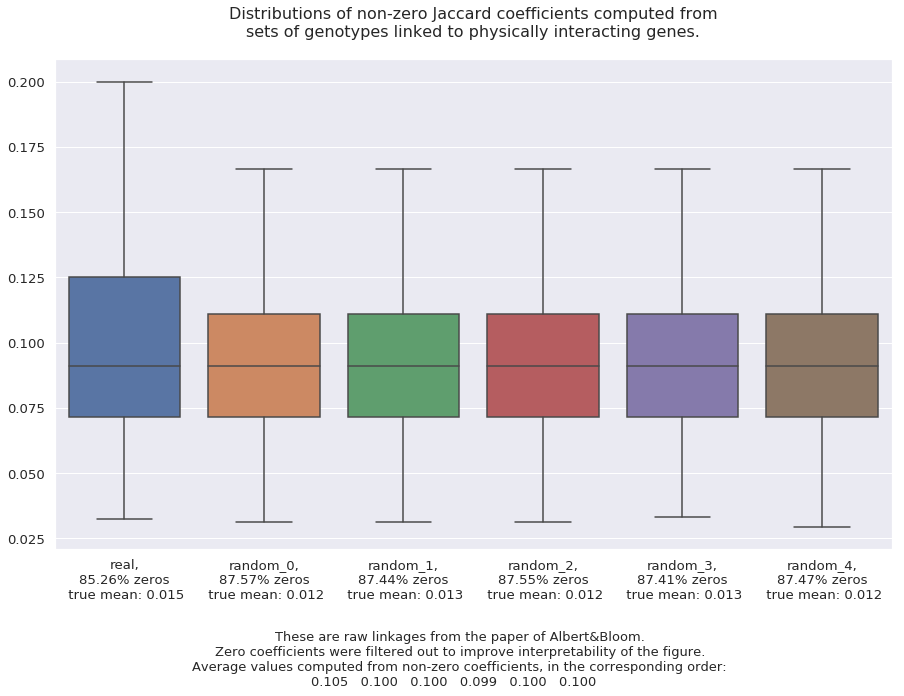

In [40]:
import matplotlib.font_manager
sns.set(style="darkgrid", font_scale=1.2)
sns.set_style({'font.family':'serif'})

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.set_title("Distributions of non-zero Jaccard coefficients computed from\n" 
             "sets of genotypes linked to physically interacting genes.\n", fontsize=16)

g = sns.boxplot(
    data=[v[v > 0] for v in j_distr_dct.values()], 
    ax=ax,
    showfliers=False
)

g.set_xticklabels(["{},\n{:.2f}% zeros\n true mean: {:.3f}".format(
    k, 100 * (v == 0).mean(), v.mean(), v[v>0].mean()) 
    for k, v in j_distr_dct.items()]
)

caption = ("These are raw linkages from the paper of Albert&Bloom.\n" 
           + "Zero coefficients were filtered out to improve interpretability of the figure.\n"
           + "Average values computed from non-zero coefficients, in the corresponding order:\n"
           + ''.join(["{:.3f}   ".format(v[v>0].mean()) for v in j_distr_dct.values()]))

fig.text(0.5, 0.010, 
         caption, 
         wrap=True, 
         horizontalalignment='center', 
         fontsize=13)

fig.subplots_adjust(bottom=0.2)

In [63]:
class Figure1:
    def __init__(self, fig, gs, ax, 
                 type2interactome, 
                 type2simulation_results, 
                 interaction_categories, 
                 score_thresholds, 
                 threshold_labels,
                 j_distr_dct,
                 caption, colors, xscale_log=False):
        
        assert (np.intersect1d(interaction_categories, list(type2interactome.keys())).size 
                == len(interaction_categories)),\
                "some passed categories are not present in simulation results: {}".format(
                    np.setdiff1d(interaction_categories, list(type2interactome.keys()))
                )
        assert (np.intersect1d(interaction_categories, list(type2simulation_results.keys())).size 
                == len(interaction_categories)),\
                "some passed categories are not present in simulation results: {}".format(
                    np.setdiff1d(interaction_categories, list(type2simulation_results.keys()))
                )
        
        self.fig = fig
        self.gs = gs
        self.ax = ax
        self.type2interactome = type2interactome
        self.type2simulation_results = type2simulation_results
        self.interaction_categories = interaction_categories
        self.score_thresholds = score_thresholds
        self.threshold_labels = threshold_labels
        self.j_distr_dct = j_distr_dct
        self.caption = caption
        self.colors = colors
        self.xscale_log = xscale_log
    
    def _setup(self):
        sns.set(style="whitegrid", font_scale=1.3)
    #     sns.set_style({'font.family':'serif'})

        self.fig.subplots_adjust(bottom=0.2, top=1, wspace=0.05)
#         self.fig.suptitle(self.suptitle, fontsize=25)
        self.fig.align_labels(axs=self.ax)
        self.fig.text(0.5, 0, self.caption, 
                      wrap=True, 
                      horizontalalignment='center', 
                      fontsize=18)
    
    def _plot_figure_1a(self):
        self.ax[0].imshow(plt.imread("img/figure-1/figure-1a.jpg"))
        self.ax[0].set_title("Figure 1a", fontsize=25, pad=16)
        self.ax[0].set_xticks([])
        self.ax[0].set_yticks([])
    
    def _plot_figure_1b(self):
        self.ax[1].set_title(
            "Figure 1b",
            fontsize=25,
            pad=16
        )

        # ax.set_ylim(0, 1)
        g = sns.boxplot(
            data=[v[v > 0] for v in self.j_distr_dct.values()][:2], 
            ax=self.ax[1],
            showfliers=False
        )

        g.set_xticklabels(["{} graph,\n{:.2f}% zeros\n true mean: {:.3f}".format(
            k.split("_")[0], 100 * (v == 0).mean(), v.mean(), v[v>0].mean()) 
            for k, v in self.j_distr_dct.items()][:2]
        )

        self.ax[1].arrow(
            0.15, 0.19, 
            0.65, -0.065, 
            color="red", head_width=0.01
        )
        
        self.ax[1].yaxis.set_ticks_position("right")
        self.ax[1].set_ylabel("linkage similarity", fontsize=18, labelpad=10)
        self.ax[1].yaxis.set_label_position("right")
    
    def _plot_figure_1c(self):
        self.ax[2].set_title("Figure 1c", fontsize=25, pad=16)
        self.ax[2].set_xlabel("linkage score threshold (LOD)", fontsize=18, labelpad=10)
        self.ax[2].set_ylabel("average linkage similarity", fontsize=18, labelpad=10)
        self.ax[2].yaxis.set_label_position("right")
        self.ax[2].yaxis.tick_right()
        if self.xscale_log: self.ax[2].set_xscale("log")
        self.ax[2].set_xticklabels(self.threshold_labels)

        for edge_type in self.interaction_categories:
            simulation_results = self.type2simulation_results[edge_type]
            significant_point_ids = list(np.where(np.ravel(simulation_results["p-value"]) <= 0.05))
            self.ax[2].plot(
                self.score_thresholds, 
                simulation_results["actual"]["linksim"]["mean"], 
                label="Interaction type (TheBioGrid): {}\nnodes: {} ({:.2f}% of all nodes)\nedges: {} ({:.2f}% of all edges)".format(
                    edge_type, 
                    self.type2interactome[edge_type].vcount(), 
                    100 * self.type2interactome[edge_type].vcount() / self.type2interactome["all"].vcount(),
                    self.type2interactome[edge_type].ecount(),
                    100 * self.type2interactome[edge_type].ecount() / self.type2interactome["all"].ecount()
                ), 
                color=self.colors[edge_type],
                linestyle="-.",
#                 marker="*",
#                 markevery=significant_point_ids,
#                 markerfacecolor="gold",
#                 markersize=15
            )
            self.ax[2].scatter(
                self.score_thresholds[significant_point_ids], 
                0.5 * (simulation_results["actual"]["linksim"]["mean"][significant_point_ids]
                       + simulation_results["random"]["linksim"]["50%"][significant_point_ids]),
                marker="*",
                facecolor="black",
                s=75
            )
            
            self.ax[2].plot(
                self.score_thresholds, 
                simulation_results["random"]["linksim"]["50%"], 
                c=self.colors[edge_type]
            )
            
            self.ax[2].fill_between(
                self.score_thresholds, 
                simulation_results["random"]["linksim"]["25%"],  
                simulation_results["random"]["linksim"]["75%"], 
                color=self.colors[edge_type], alpha=0.25
            )

            legend = self.ax[2].legend(loc="upper left", fontsize=15);
            frame = legend.get_frame();
            frame.set_facecolor("white");
            frame.set_edgecolor("black");
            self.ax[2].ticklabel_format(style='sci', axis='y', scilimits=(-2,2))

    
    def plot(self):
        self._setup()
        self._plot_figure_1a()
        self._plot_figure_1b()
        self._plot_figure_1c()
        self.fig.savefig("img/figure-1/figure-1.jpg", dpi=300)
    

/home/common/ivanov.vv/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/common/ivanov.vv/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


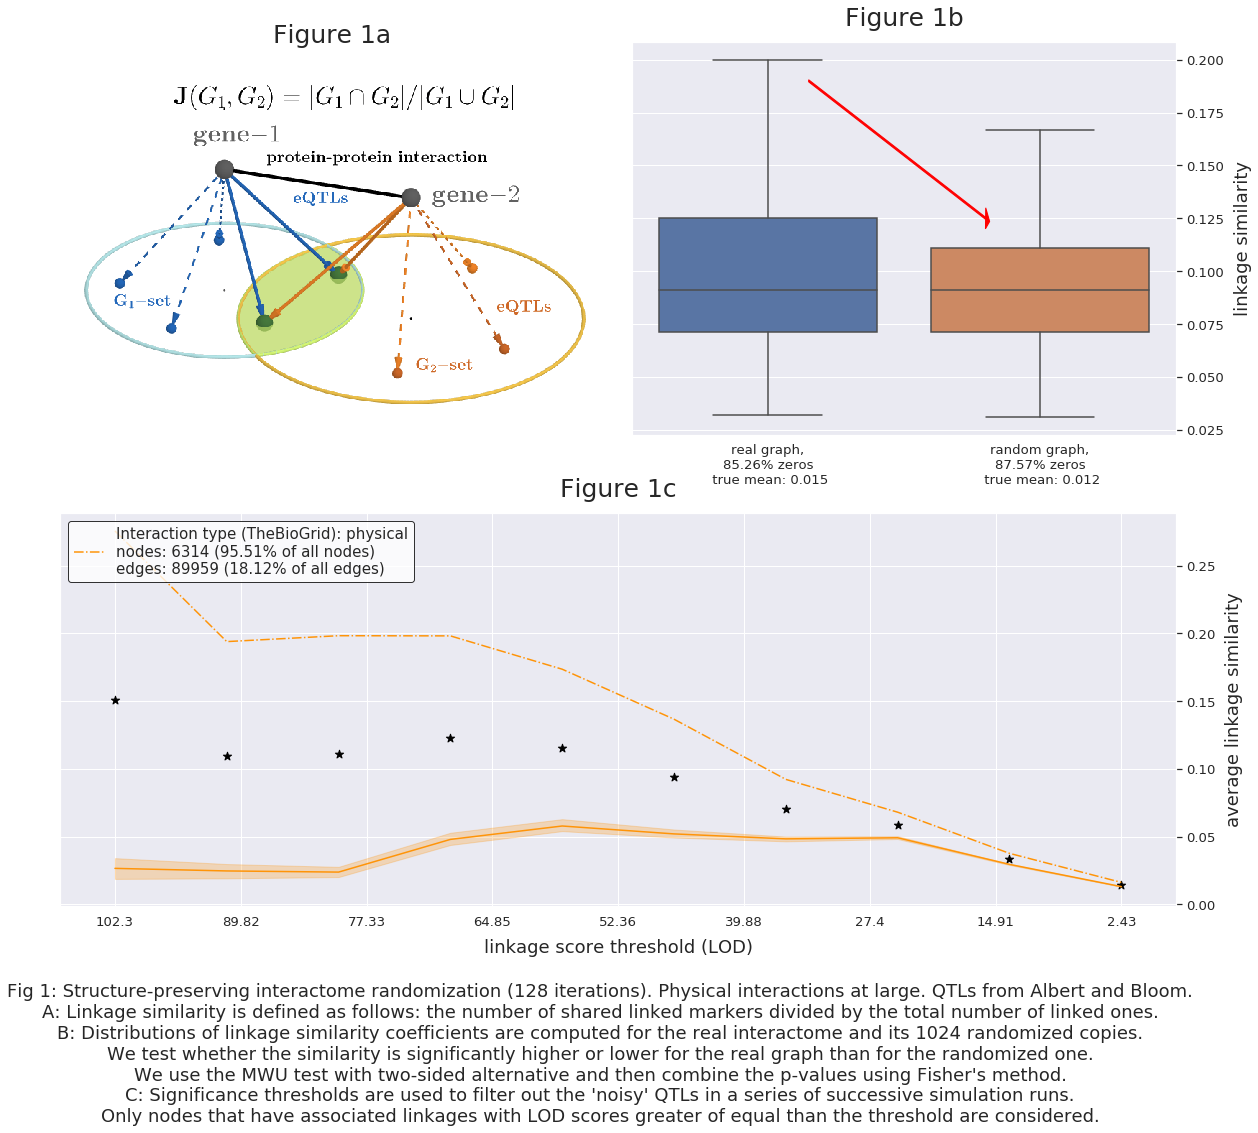

In [27]:
fig = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(2, 2, height_ratios=[1,1])
ax = [fig.add_subplot(gs[0, 0]), 
      fig.add_subplot(gs[0, 1]), 
      fig.add_subplot(gs[1, :])]

Figure1(
    fig, gs, ax,
    type2interactome, type2simulation_results, 
    interaction_categories=["physical"],
    score_thresholds=score_thresholds,
    threshold_labels=[np.round(x, 2)[0] for x in 
                      scaler_df["eQTLs_2018"]["A&B"].inverse_transform(
                          (1 - score_thresholds)[:, None]
                      )],
    j_distr_dct=j_distr_dct,
    colors={"all" : "black",
            "genetic" : "xkcd:azure", 
            "physical" : "xkcd:tangerine"},
    caption="Fig 1: Structure-preserving interactome randomization (128 iterations). "
            "Physical interactions at large. QTLs from Albert and Bloom.\n"
            "A: Linkage similarity is defined as follows: the number of shared linked markers divided by the total number of linked ones.\n"
            "B: Distributions of linkage similarity coefficients are computed for the real interactome and its 1024 randomized copies.\n"
            "We test whether the similarity is significantly higher or lower for the real graph than for the randomized one.\n"
            "We use the MWU test with two-sided alternative and then combine the p-values using Fisher's method.\n"
            "C: Significance thresholds are used to filter out the 'noisy' QTLs in a series of successive simulation runs.\n" 
            "Only nodes that have associated linkages with LOD scores greater of equal than the threshold are considered."
).plot()

## Cis- and trans-acting QTLs

In [58]:
cis_lod_thresholds = np.array([15, 10, 8, 6, 4, 2.5])
cis_score_thresholds = np.ravel(1 - scaler_df["eQTLs_2018"]["A&B"].transform(cis_lod_thresholds[:, None]))
spr_test_cis = qtls.RandomizedInteractomeTest(
    interactome=type2interactome["physical"], 
    interactions_type=category["physical"],
    qtls_df=qtls_df["eQTLs_2018"]["A&B"].query("cis == 1"),
    score_thresholds=cis_score_thresholds,
    path_to_randomized="data/raw/randomized_interactome_copies/",
    max_iter=128, 
    n_jobs=cis_score_thresholds.size)
cis_simres = {"physical" : spr_test_cis.map_reduce()}

In [61]:
cis_simres

{'physical': {'actual': {'linksim': {'mean': array([0.00000000e+00, 1.48698885e-04, 1.12701454e-04, 8.85582713e-05,
           1.25667609e-04, 1.49246306e-04])}},
  'p-value': array([1., 1., 1., 1., 1., 1.]),
  'random': {'linksim': {'25%': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           5.56588306e-05, 5.06656202e-05]),
    '50%': array([0.00000000e+00, 1.52520400e-04, 1.14982179e-04, 9.09256228e-05,
           6.43231612e-05, 1.09984441e-04]),
    '75%': array([0.00022007, 0.00015508, 0.00011669, 0.00018071, 0.00012832,
           0.00015217])}}}}

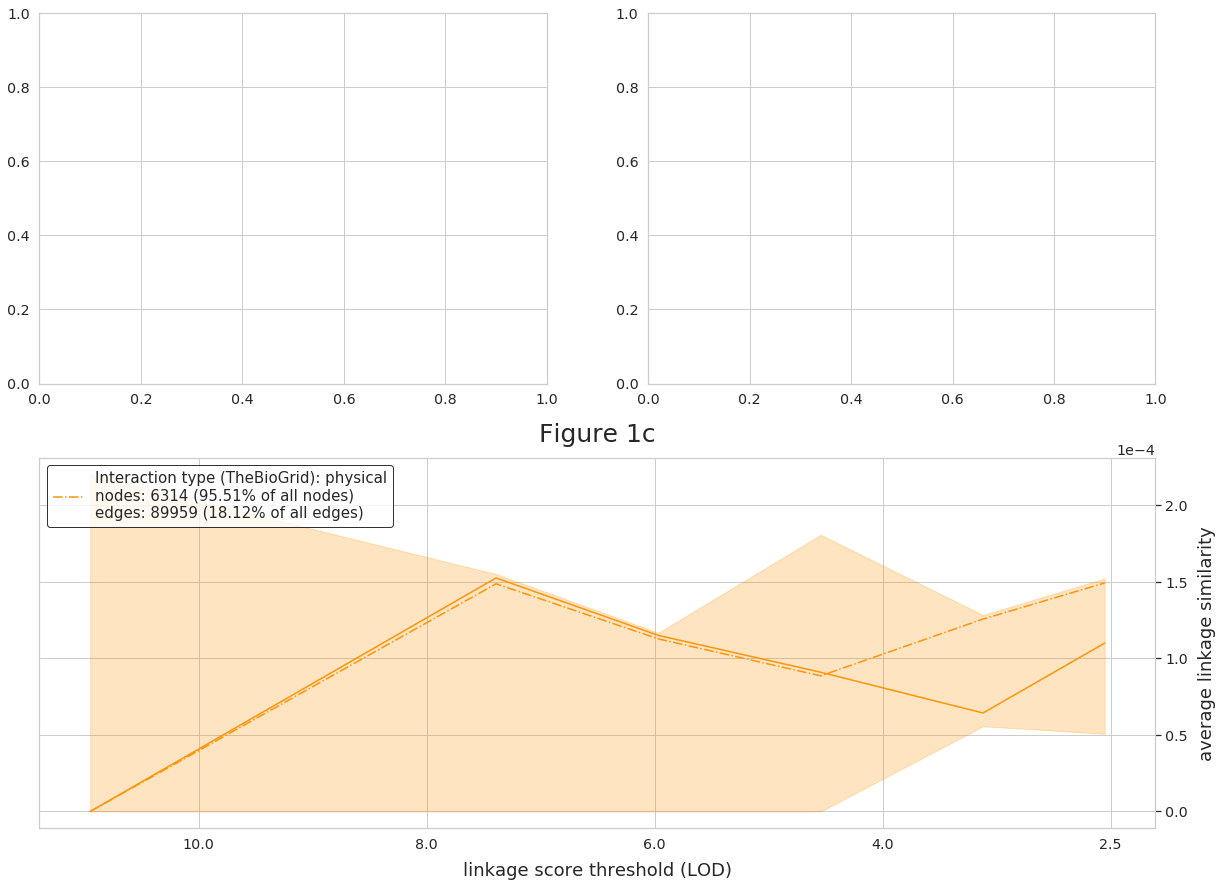

In [69]:
fig = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(2, 2, height_ratios=[1,1])
ax = [fig.add_subplot(gs[0, 0]), 
      fig.add_subplot(gs[0, 1]), 
      fig.add_subplot(gs[1, :])]

Figure1(
    fig, gs, ax,
    type2interactome, cis_simres, 
    interaction_categories=["physical"],
    score_thresholds=cis_score_thresholds,
    threshold_labels=cis_lod_thresholds,
    j_distr_dct=j_distr_dct,
    colors={"all" : "black",
            "genetic" : "xkcd:azure", 
            "physical" : "xkcd:tangerine"},
    caption="Fig 1: Structure-preserving interactome randomization (128 iterations). "
            "Physical interactions at large. Cis-acting eQTLs from Albert and Bloom.\n"
            "A: Linkage similarity is defined as follows: the number of shared linked markers divided by the total number of linked ones.\n"
            "B: Distributions of linkage similarity coefficients are computed for the real interactome and its 1024 randomized copies.\n"
            "We test whether the similarity is significantly higher or lower for the real graph than for the randomized one.\n"
            "We use the MWU test with two-sided alternative and then combine the p-values using Fisher's method.\n"
            "C: Significance thresholds are used to filter out the 'noisy' QTLs in a series of successive simulation runs.\n" 
            "Only nodes that have associated linkages with LOD scores greater of equal than the threshold are considered."
)._plot_figure_1c()

In [48]:
spr_test_trans = qtls.RandomizedInteractomeTest(
    interactome=type2interactome["physical"], 
    interactions_type=category["physical"],
    qtls_df=qtls_df["eQTLs_2018"]["A&B"].query("cis == 0"),
    score_thresholds=score_thresholds,
    path_to_randomized="data/raw/randomized_interactome_copies/",
    max_iter=128, 
    n_jobs=score_thresholds.size)
trans_simres = {"physical" : spr_test_trans.map_reduce()}

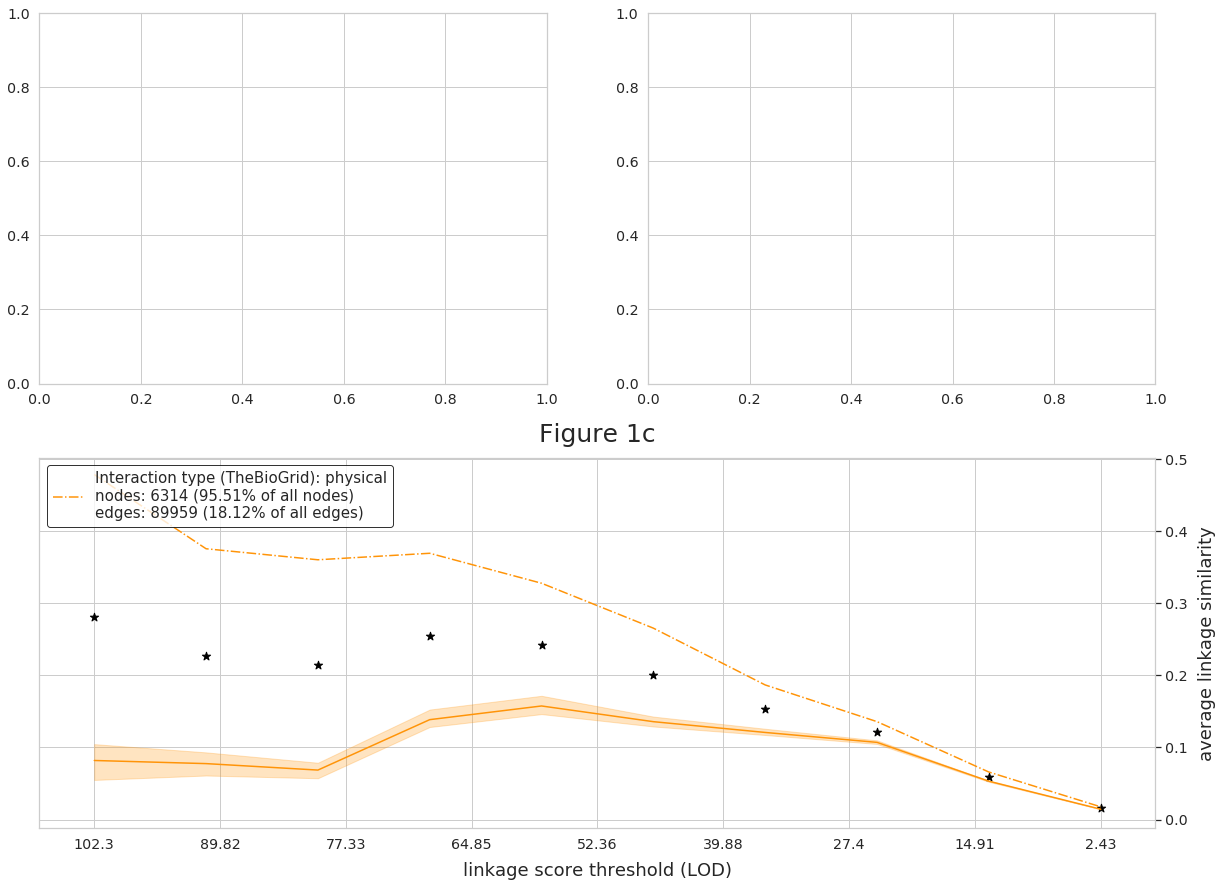

In [67]:
fig = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(2, 2, height_ratios=[1,1])
ax = [fig.add_subplot(gs[0, 0]), 
      fig.add_subplot(gs[0, 1]), 
      fig.add_subplot(gs[1, :])]

Figure1(
    fig, gs, ax,
    type2interactome, trans_simres, 
    interaction_categories=["physical"],
    score_thresholds=score_thresholds,
    threshold_labels=[np.round(x, 2)[0] for x in 
                      scaler_df["eQTLs_2018"]["A&B"].inverse_transform(
                          (1 - score_thresholds)[:, None]
                      )],
    j_distr_dct=j_distr_dct,
    colors={"all" : "black",
            "genetic" : "xkcd:azure", 
            "physical" : "xkcd:tangerine"},
    caption="Fig 1: Structure-preserving interactome randomization (128 iterations). "
            "Physical interactions at large. Trans-acting eQTLs from Albert and Bloom.\n"
            "A: Linkage similarity is defined as follows: the number of shared linked markers divided by the total number of linked ones.\n"
            "B: Distributions of linkage similarity coefficients are computed for the real interactome and its 1024 randomized copies.\n"
            "We test whether the similarity is significantly higher or lower for the real graph than for the randomized one.\n"
            "We use the MWU test with two-sided alternative and then combine the p-values using Fisher's method.\n"
            "C: Significance thresholds are used to filter out the 'noisy' QTLs in a series of successive simulation runs.\n" 
            "Only nodes that have associated linkages with LOD scores greater of equal than the threshold are considered."
)._plot_figure_1c()

## Conclusions

1. Cis-eQTLs don't really tend to share linkages. Not sure why.
2. On the other hand, **almost all (92%) eQTLs estimated by A&B's algorithm are acting in trans**:

In [72]:
# count the fraction of cis- and trans-acting eQTLs
n_tot = qtls_df["eQTLs_2018"]["A&B"].shape[0]
n_cis = qtls_df["eQTLs_2018"]["A&B"].query("cis == 1").shape[0]
n_trans = n_tot - n_cis
print("{} cis-eQTLs ({}%), {} trans-eQTLs ({}%)".format(
    n_cis, round(100 * n_cis / n_tot, 2), 
    n_trans, round(100 * n_trans / n_tot, 2)
))

2969 cis-eQTLs (8.13%), 33529 trans-eQTLs (91.87%)


And I am almost sure that it's **not** a coincidence: for each gene their algorithm selects only **one** candidate from the same chromosome per iteration. The algorithm is biased by design to select more trans-acting QTLs simply because it tests more markers from other chromosomes (15 to 1, to be precise).  
It's weird that these cis-acting QTLs are of such a low quality. Is it the same with our old dataset?

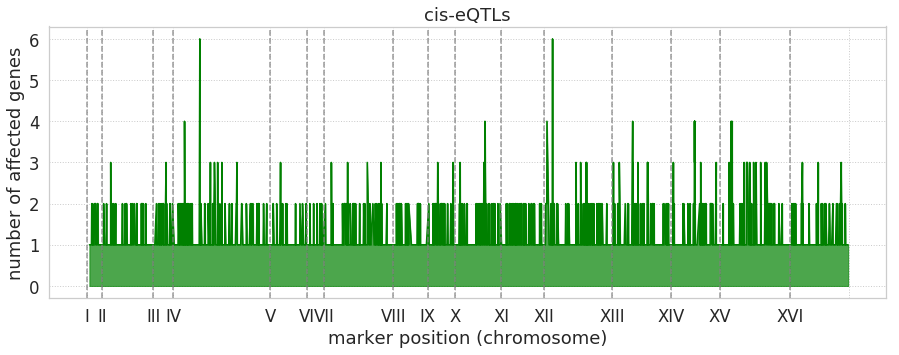

In [87]:
qtls.QTLDistPlotter(
    qtl_df=qtls_df["eQTLs_2018"]["A&B"].query("cis == True"),
    qtl_type="physical", 
    figsize=(15,5), 
    title="cis-eQTLs", 
    font_scale=1.5
);

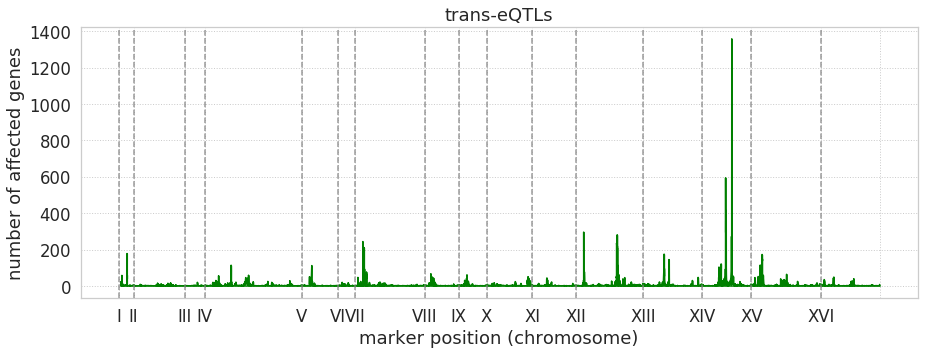

In [88]:
QTLDistPlotter(
    qtl_df=qtls_df["eQTLs_2018"]["A&B"].query("cis == False"),
    qtl_type="physical", 
    figsize=(15,5), 
    title="trans-eQTLs", 
    font_scale=1.5
);

## A&B's data, limix algorithm

In [81]:
type2simulation_results = {}
score_thresholds = (10. ** np.arange(-8, -1))
assert np.all(score_thresholds == (10. ** np.arange(-8, -1)))
for edge_type in tqdm_notebook(interaction_categories):
    print(edge_type)
    rptest = qtls.RandomizedInteractomeTest(type2interactome[edge_type], 
                                       category[edge_type],
                                       qtls_df["eQTLs_2018"]["limix"],
                                       score_thresholds,
                                       "data/raw/randomized_interactome_copies/",
                                       max_iter=128, 
                                       n_jobs=score_thresholds.size)
    type2simulation_results[edge_type] = rptest.map_reduce()

additive genetic interaction defined by inequality


NameError: name 'RandomizedInteractomeTest' is not defined

In [ ]:
# with open("data/tmp/figure-2/type2simulation_results_limix_eQTLs_2018.pkl", "wb") as outfile:
#     pickle.dump(type2simulation_results, outfile)

In [241]:
with open("data/tmp/figure-2/type2simulation_results_limix_eQTLs_2018.pkl", "rb") as infile:
    type2simulation_results = pickle.load(infile)

## Our old eQTLs, naive algorithm:

In [ ]:
""" Run simulations from scratch and dump results on disk. """

type2simulation_results = {}
score_thresholds = (10. ** np.arange(-8, -1))
assert np.all(score_thresholds == (10. ** np.arange(-8, -1)))
for edge_type in tqdm_notebook(interaction_categories):
    if edge_type not in ["all", "genetic", "physical"]:
        continue
    print(edge_type)
#     for edge_type in ["all", "genetic"]:
    rptest = qtls.RandomizedInteractomeTest(
        type2interactome[edge_type], 
        category[edge_type],
        qtls_df["eQTLs_2011"]["naive"],
        score_thresholds,
        "data/raw/randomized_interactome_copies/",
        max_iter=128, 
        n_jobs=min(32, score_thresholds.size)
    )
    type2simulation_results[edge_type] = rptest.map_reduce()

all


In [ ]:
with open("data/tmp/figure-2/type2simulation_results_naive_eQTLs_2011.pkl", "wb") as outfile:
    pickle.dump(type2simulation_results, outfile)

In [240]:
with open("data/tmp/figure-2/type2simulation_results_naive_eQTLs_2011.pkl", "rb") as infile:
    type2simulation_results = pickle.load(infile)

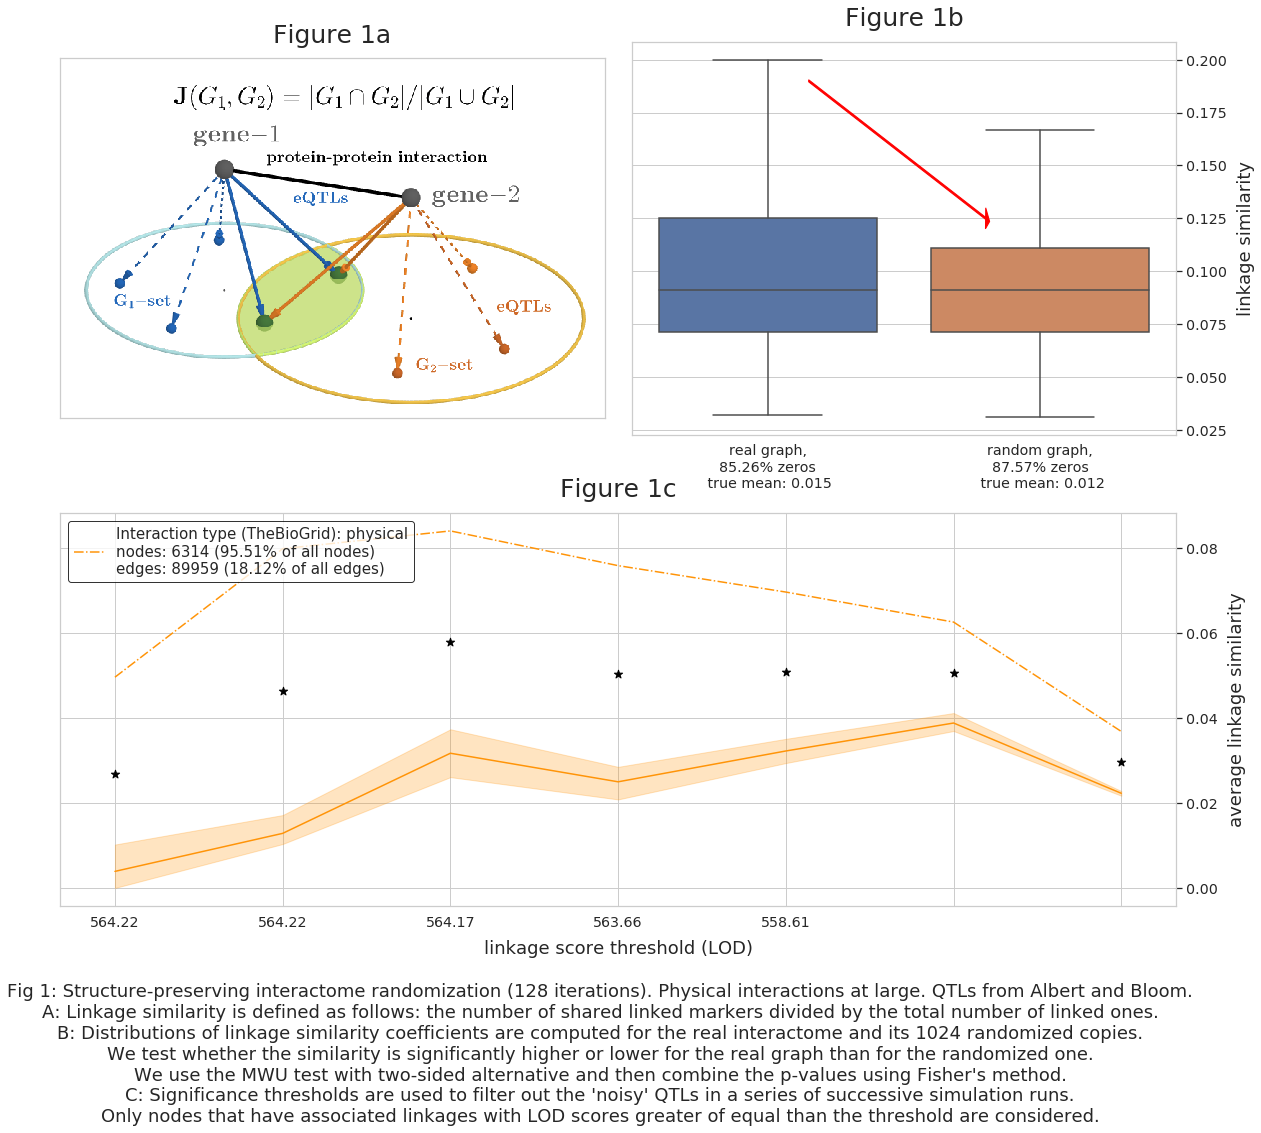

In [93]:
fig = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(2, 2, height_ratios=[1,1])
ax = [fig.add_subplot(gs[0, 0]), 
      fig.add_subplot(gs[0, 1]), 
      fig.add_subplot(gs[1, :])]

Figure1(
    fig, gs, ax,
    type2interactome, type2simulation_results, 
    interaction_categories=["physical"],
    score_thresholds=score_thresholds,
    threshold_labels=[np.round(x, 2)[0] for x in 
                      scaler_df["eQTLs_2018"]["A&B"].inverse_transform(
                          (1 - score_thresholds)[:, None]
                      )],
    j_distr_dct=j_distr_dct,
    colors={"all" : "black",
            "genetic" : "xkcd:azure", 
            "physical" : "xkcd:tangerine"},
    caption="Fig 1: Structure-preserving interactome randomization (128 iterations). "
            "Physical interactions at large. QTLs from Albert and Bloom.\n"
            "A: Linkage similarity is defined as follows: the number of shared linked markers divided by the total number of linked ones.\n"
            "B: Distributions of linkage similarity coefficients are computed for the real interactome and its 1024 randomized copies.\n"
            "We test whether the similarity is significantly higher or lower for the real graph than for the randomized one.\n"
            "We use the MWU test with two-sided alternative and then combine the p-values using Fisher's method.\n"
            "C: Significance thresholds are used to filter out the 'noisy' QTLs in a series of successive simulation runs.\n" 
            "Only nodes that have associated linkages with LOD scores greater of equal than the threshold are considered.",
    xscale_log=True
).plot()

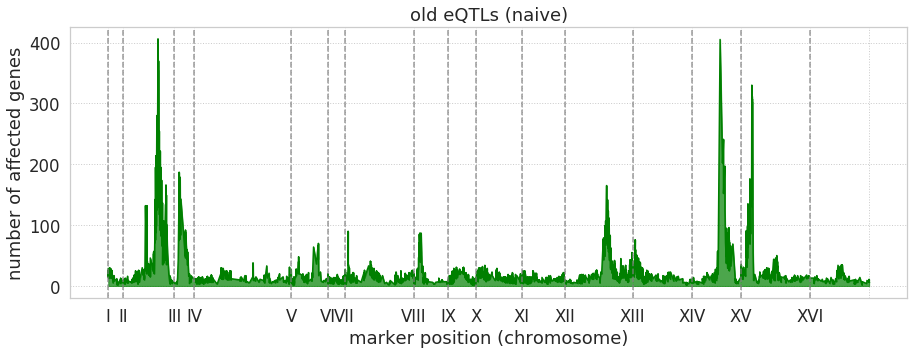

In [90]:
QTLDistPlotter(
    qtl_df=qtls_df["eQTLs_2011"]["naive"],
    qtl_type="physical", 
    figsize=(15,5), 
    title="old eQTLs (naive)", 
    font_scale=1.5
);

## Our old eQTLs, limix algorithm

In [16]:
""" Run simulations from scratch and dump results on disk. """

type2simulation_results = {}
score_thresholds = (10. ** np.arange(-8, -1))
assert np.all(score_thresholds == (10. ** np.arange(-8, -1)))
for edge_type in tqdm_notebook(interaction_categories):
    print(edge_type)
    rptest = RandomizedInteractomeTest(type2interactome[edge_type], 
                                       category[edge_type],
                                       qtls_df["eQTLs_2011"]["limix"],
                                       score_thresholds,
                                       "data/raw/randomized_interactome_copies/",
                                       max_iter=128, 
                                       n_jobs=min(32, score_thresholds.size))
    type2simulation_results[edge_type] = rptest.map_reduce()

additive genetic interaction defined by inequality
suppressive genetic interaction defined by inequality
synthetic genetic interaction defined by inequality
association
colocalization
direct interaction
physical association
all
physical
genetic



In [17]:
# with open("data/tmp/figure-2/type2simulation_results_limix_eQTLs_2011.pkl", "wb") as outfile:
#     pickle.dump(type2simulation_results, outfile)

In [237]:
with open("data/tmp/figure-2/type2simulation_results_limix_eQTLs_2011.pkl", "rb") as infile:
    type2simulation_results = pickle.load(infile)

## Our old pQTLs

In [33]:
""" Run simulations from scratch and dump results on disk. """

type2simulation_results = {}
score_thresholds = (10. ** np.arange(-8, -1))
assert np.all(score_thresholds == (10. ** np.arange(-8, -1)))
for edge_type in tqdm_notebook(interaction_categories):
#     if edge_type not in ["all", "genetic", "physical"]:
#         continue
    print(edge_type)
#     for edge_type in ["all", "genetic"]:
    rptest = RandomizedInteractomeTest(type2interactome[edge_type], 
                                       category[edge_type],
                                       qtls_df["pQTLs_2011"],
                                       score_thresholds,
                                       "data/raw/randomized_interactome_copies/",
                                       max_iter=128, 
                                       n_jobs=min(32, score_thresholds.size))
    type2simulation_results[edge_type] = rptest.map_reduce()

additive genetic interaction defined by inequality
suppressive genetic interaction defined by inequality
synthetic genetic interaction defined by inequality
association
colocalization
direct interaction
physical association
all
physical
genetic



In [34]:
# with open("data/tmp/figure-2/type2simulation_results_naive_pQTLs_2011.pkl", "wb") as outfile:
#     pickle.dump(type2simulation_results, outfile)

In [239]:
with open("data/tmp/figure-2/type2simulation_results_naive_pQTLs_2011.pkl", "rb") as infile:
    type2simulation_results = pickle.load(infile)